In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

import matplotlib.pyplot as plt
import seaborn as sns; sns.set()

%matplotlib inline

In [2]:
n = 1000

x = tf.random.normal(mean=0, stddev=1, shape=(n, 1))
ones = tf.ones(shape=(n, 1))

X = tf.concat([ones, x], axis=1)

In [3]:
beta = tf.constant([[1.0], [3.0]])

In [4]:
epsilon = tf.random.normal(mean=0, stddev=1, shape=(n, 1))

y = tf.linalg.matmul(X, beta) + epsilon 

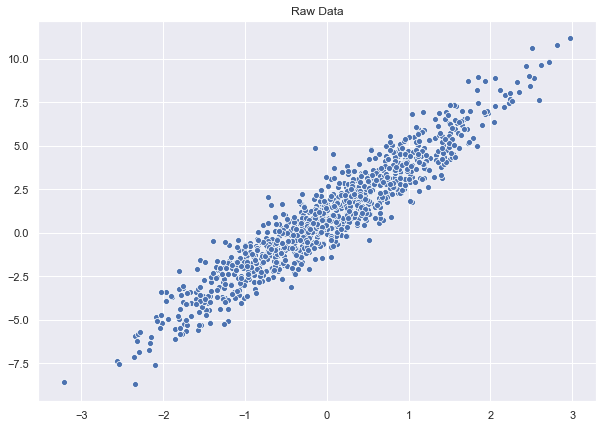

In [5]:
plt.rcParams['figure.figsize'] = (10,7)

fig, ax = plt.subplots()

sns.scatterplot(
    x=X[:, 1].numpy().flatten(), 
    y=y.numpy().flatten(), 
    ax=ax
)

ax.set(title='Raw Data');

In [6]:
train_size = int(0.75 * n)
test_size = n - train_size

In [7]:
X_train, X_test = tf.split(value=X, num_or_size_splits=(train_size, test_size))
y_train, y_test = tf.split(value=y, num_or_size_splits=(train_size, test_size))

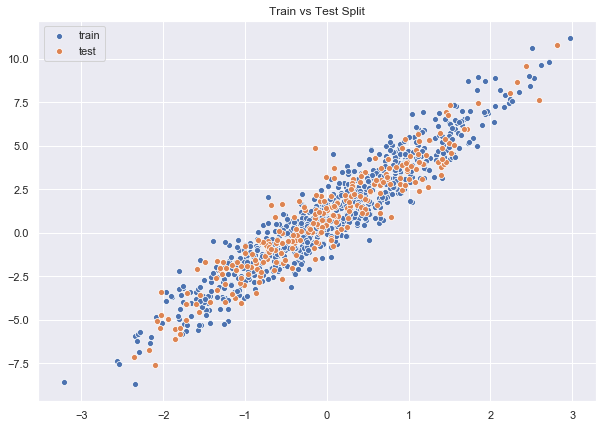

In [8]:
fig, ax = plt.subplots()

sns.scatterplot(
    x=X_train[:, 1].numpy().flatten(), 
    y=y_train.numpy().flatten(), 
    ax=ax, 
    label='train'
)

sns.scatterplot(
    x=X_test[:, 1].numpy().flatten(), 
    y=y_test.numpy().flatten(), 
    ax=ax, 
    label='test'
)

ax.set(title='Train vs Test Split')
ax.legend();

In [37]:
def build_model():
    
    model = keras.Sequential([
        layers.Dense(1, activation='relu', input_shape=[X_train.shape[1]]),
        layers.Dense(1)
    ])

    optimizer = tf.keras.optimizers.RMSprop(0.001)

    model.compile(loss='mse',
                  optimizer=optimizer,
                  metrics=['mae', 'mse'])
    
    return model

In [38]:
model = build_model()

In [39]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_6 (Dense)              (None, 1)                 3         
_________________________________________________________________
dense_7 (Dense)              (None, 1)                 2         
Total params: 5
Trainable params: 5
Non-trainable params: 0
_________________________________________________________________


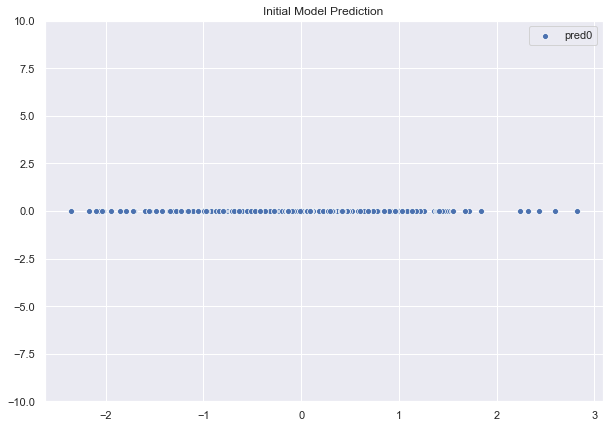

In [40]:
fig, ax = plt.subplots()

y_pred0 = model.predict(X_test)

sns.scatterplot(
    x=X_test[:, 1].numpy().flatten(), 
    y=y_pred0.flatten(), 
    ax=ax, 
    label='pred0'
)

ax.set(title='Initial Model Prediction', ylim=(-10, 10))
ax.legend();

In [41]:
# Display training progress by printing a single dot for each completed epoch
class PrintDot(keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs):
        if epoch % 100 == 0: print('')
        print('.', end='')

EPOCHS = 1000

history = model.fit(
    x=X_train, 
    y=y_train,
    epochs=EPOCHS, 
    validation_split=0.2,
    verbose=0,
    callbacks=[PrintDot()])


....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
..........................................................................................

In [42]:
hist_df = pd.DataFrame(history.history)
hist_df['epoch'] = history.epoch

hist_df.head()

,loss,mae,mse,val_loss,val_mae,val_mse,epoch
0,10.982091,2.593855,10.982092,10.854108,2.604227,10.854108,0
1,10.939329,2.589276,10.939328,10.807585,2.599628,10.807585,1
2,10.898987,2.585136,10.898987,10.756842,2.594641,10.756844,2
3,10.855383,2.580708,10.855384,10.704818,2.589560,10.704818,3
4,10.807320,2.576230,10.807321,10.645298,2.583726,10.645298,4


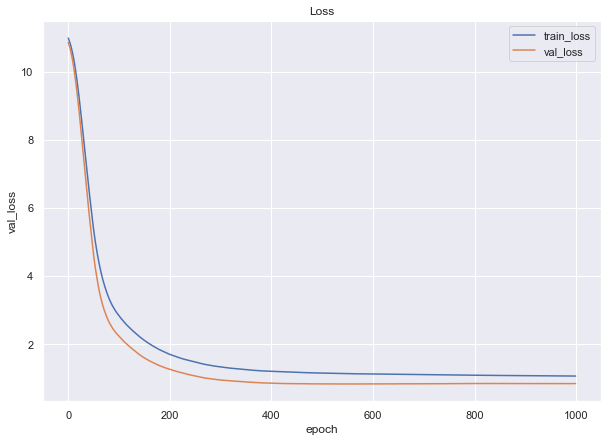

In [43]:
fig, ax = plt.subplots()

sns.lineplot(x='epoch', y='loss', data=hist_df, ax=ax, label='train_loss')
sns.lineplot(x='epoch', y='val_loss', data=hist_df, ax=ax, label='val_loss')

ax.set(title='Loss');

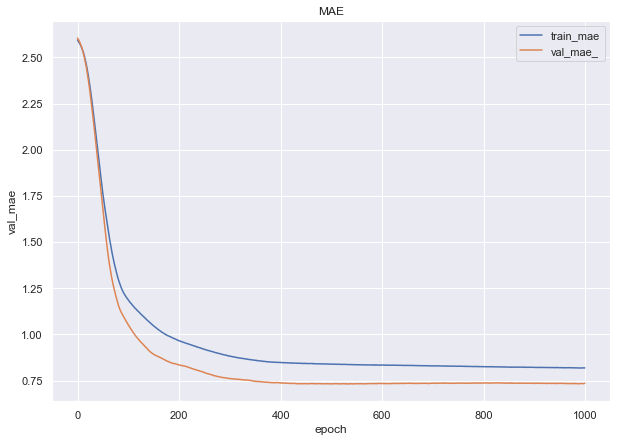

In [44]:
fig, ax = plt.subplots()

sns.lineplot(x='epoch', y='mae', data=hist_df, ax=ax, label='train_mae')
sns.lineplot(x='epoch', y='val_mae', data=hist_df, ax=ax, label='val_mae_')

ax.set(title='MAE');

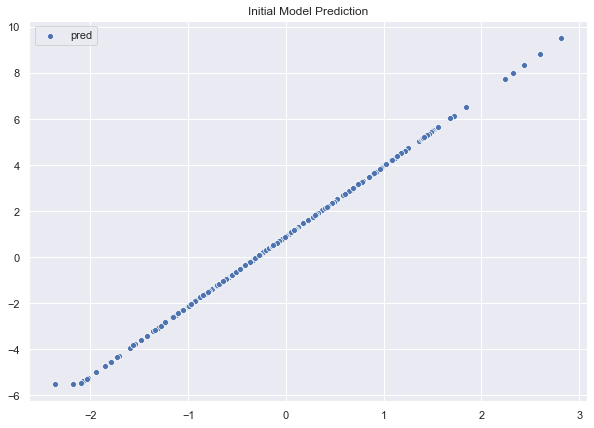

In [45]:
fig, ax = plt.subplots()

y_pred = model.predict(X_test)


sns.scatterplot(
    x=X_test[:, 1].numpy().flatten(), 
    y=y_pred.flatten(), 
    ax=ax, 
    label='pred'
)

ax.set(title='Initial Model Prediction')
ax.legend();

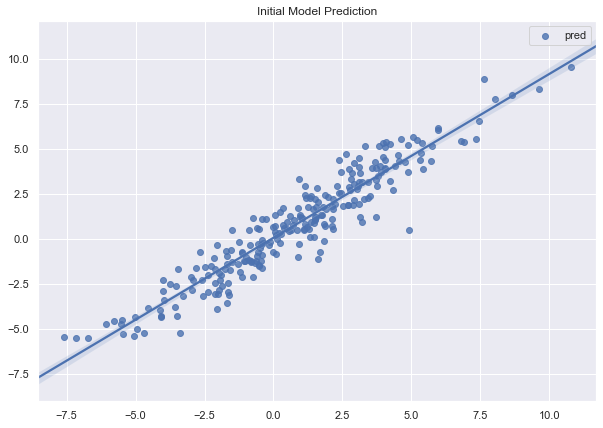

In [46]:
fig, ax = plt.subplots()

sns.regplot(
    x=y_test.numpy().flatten(), 
    y=y_pred.flatten(), 
    ax=ax, 
    label='pred'
)

ax.set(title='Initial Model Prediction')
ax.legend();